# Project

# Import libraries

In [441]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
from itertools import product
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objs as go
from math import sqrt
import sys
from scipy import spatial
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

# Read files

In [442]:
sales_train = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("competitive-data-science-predict-future-sales/test.csv").set_index('ID')
sample_submission = pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")
items =  pd.read_csv("competitive-data-science-predict-future-sales/items.csv", encoding="UTF-8")
item_categories = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv", encoding="UTF-8")
shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")

# Check if there are null values

In [443]:
df_missingvals_train = sales_train.isna()
#Sum null vals
df_missingvals_train_sum = df_missingvals_train.sum()
#percentage missing
print(df_missingvals_train_sum/len(sales_train))

date             0.000000
date_block_num   0.000000
shop_id          0.000000
item_id          0.000000
item_price       0.000000
item_cnt_day     0.000000
dtype: float64


In [444]:
df_missingvals_test = test.isna()
#Sum null vals
df_missingvals_test_sum = df_missingvals_test.sum()
#percentage missing
print(df_missingvals_test_sum/len(test))

shop_id   0.000000
item_id   0.000000
dtype: float64


# Join everything to get names

In [445]:
join_df = pd.merge(sales_train, shops, how ='inner', on ='shop_id')
join_df =  pd.merge(join_df, items, how ='inner', on ='item_id')
join_df = pd.merge(join_df,item_categories,how='inner',on='item_category_id')
join_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.000000,1.000000,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.000000,1.000000,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


# Overall statistics

In [446]:
pd.set_option('float_format', '{:f}'.format)
join_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641,40.001383
std,9.422988,16.226973,6324.297354,1729.799631,2.618834,17.100759
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000,83.000000


# Detect outliers

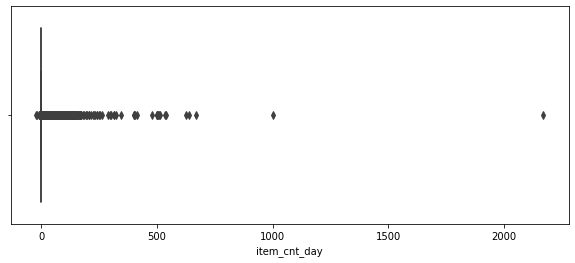

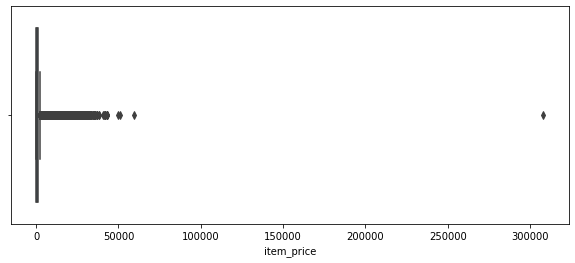

In [447]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=sales_train.item_price)

In [448]:
#We will keep everything except the outliers detected previously
join_df_filter = join_df[join_df['item_cnt_day']<1001]
join_df_filter = join_df[join_df['item_price']<100000]

In [449]:
median = join_df_filter[(join_df_filter.shop_id==32)&(join_df_filter.item_id==2973)&(join_df_filter.date_block_num==4)&(join_df_filter.item_price>0)].item_price.median()
join_df_filter.loc[join_df_filter.item_price<0, 'item_price'] = median
join_df_filter.loc[join_df_filter.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
join_df_filter.loc[join_df_filter.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
join_df_filter.loc[join_df_filter.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [450]:
final_df_model = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    final_df_model.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
final_df_model = pd.DataFrame(np.vstack(final_df_model), columns=cols)
#final_df_model['date_block_num'] = matrix['date_block_num'].astype(np.int8)
#final_df_model['shop_id'] = matrix['shop_id'].astype(np.int8)
#final_df_model['item_id'] = matrix['item_id'].astype(np.int16)
final_df_model.sort_values(cols,inplace=True)

In [451]:
join_df_filter['items_sold'] = join_df_filter['item_price'] *  join_df_filter['item_cnt_day']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Create item_cnt_month feature. The end prediction would be by month, so we will proceed to do the aggregation

In [452]:
itemcntmonth = join_df_filter.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
itemcntmonth.columns = ['item_cnt_month']
itemcntmonth.reset_index(inplace=True)
final_df_model = pd.merge(final_df_model, itemcntmonth, on=['date_block_num','shop_id','item_id'], how='left')
final_df_model['item_cnt_month'] = (final_df_model['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                )
#.astype(np.float16)

In [453]:
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.000000
1,0,0,27,0.000000
2,0,0,28,0.000000
3,0,0,29,0.000000
4,0,0,32,0.000000


# We have date_block_nums from 1 to 33. In order to handle it more easy we will define the date_block_num for the test data as 34 and treat it as a single dataframe with the train df.

In [454]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num']
final_df_model = pd.concat([final_df_model, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
final_df_model.fillna(0, inplace=True) # 34 month
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.000000
1,0,0,27,0.000000
2,0,0,28,0.000000
3,0,0,29,0.000000
4,0,0,32,0.000000


In [455]:
len(final_df_model)

11128050

In [456]:
final_df_model = pd.merge(final_df_model, shops, on=['shop_id'], how='left')
final_df_model = pd.merge(final_df_model, items, on=['item_id'], how='left')
final_df_model = pd.merge(final_df_model, item_categories, on=['item_category_id'], how='left')

In [458]:
#Following methods from https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/
#Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.
#The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1). 
#In this case we will increase it by 3 times, meaning a projection for the next 3 months.

def lag_feature(df, lags, col):
    join_df = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = join_df.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [459]:
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.000000,29,40,11,4
1,0,0,27,0.000000,29,19,5,10
2,0,0,28,0.000000,29,30,8,55
3,0,0,29,0.000000,29,23,5,16
4,0,0,32,0.000000,29,40,11,4


In [460]:
final_df_model = lag_feature(final_df_model, [1,2,3,6,12], 'item_cnt_month')
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.000000,29,40,11,4,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,nan,nan,nan


# Adding average features to current dataset

In [461]:
avg_item_permonth = final_df_model.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
avg_item_permonth.columns = [ 'avg_item_permonth' ]
avg_item_permonth.reset_index(inplace=True)
final_df_model = pd.merge(final_df_model, avg_item_permonth, on=['date_block_num'], how='left')
final_df_model['avg_item_permonth'] = final_df_model['avg_item_permonth'].astype(np.float16)
final_df_model = lag_feature(final_df_model, [1], 'avg_item_permonth')#col 1 cause we will project date_block_num
final_df_model.drop(['avg_item_permonth'], axis=1, inplace=True)
final_df_model.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,avg_item_permonth_lag_1
0,0,0,19,0.000000,29,40,11,4,nan,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,nan,nan,nan,nan


In [462]:
avg_item_cnt_bydate = final_df_model.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
avg_item_cnt_bydate.columns = [ 'avg_item_cnt_bydate' ]
avg_item_cnt_bydate.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_cnt_bydate, on=['date_block_num','item_id'], how='left')
final_df_model['avg_item_cnt_bydate'] = final_df_model['avg_item_cnt_bydate'].astype(np.float16)
final_df_model = lag_feature(final_df_model, [1,2,3,6,12], 'avg_item_cnt_bydate')
final_df_model.drop(['avg_item_cnt_bydate'], axis=1, inplace=True)
final_df_model.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,avg_item_permonth_lag_1,avg_item_cnt_bydate_lag_1,avg_item_cnt_bydate_lag_2,avg_item_cnt_bydate_lag_3,avg_item_cnt_bydate_lag_6,avg_item_cnt_bydate_lag_12
0,0,0,19,0.000000,29,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [464]:
avg_item_pershop = final_df_model.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
avg_item_pershop.columns = [ 'avg_item_pershop' ]
avg_item_pershop.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_pershop, on=['date_block_num','shop_id'], how='left')
final_df_model['avg_item_pershop'] = final_df_model['avg_item_pershop'].astype(np.float16)
final_df_model = lag_feature(final_df_model, [1,2,3,6,12], 'avg_item_pershop')
final_df_model.drop(['avg_item_pershop'], axis=1, inplace=True)
final_df_model.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cnt_bydate_lag_1,avg_item_cnt_bydate_lag_2,avg_item_cnt_bydate_lag_3,avg_item_cnt_bydate_lag_6,avg_item_cnt_bydate_lag_12,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [465]:
avg_item_percategory = final_df_model.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
avg_item_percategory.columns = [ 'avg_item_percategory' ]
avg_item_percategory.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_percategory, on=['date_block_num','item_category_id'], how='left')
final_df_model['avg_item_percategory'] = final_df_model['avg_item_percategory'].astype(np.float16)
final_df_model = lag_feature(final_df_model, [1], 'avg_item_percategory')
final_df_model.drop(['avg_item_percategory'], axis=1, inplace=True)
final_df_model.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cnt_bydate_lag_2,avg_item_cnt_bydate_lag_3,avg_item_cnt_bydate_lag_6,avg_item_cnt_bydate_lag_12,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [466]:
avg_item_percategoryandshop = final_df_model.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
avg_item_percategoryandshop.columns = ['avg_item_percategoryandshop']
avg_item_percategoryandshop.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_percategoryandshop, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
final_df_model['avg_item_percategoryandshop'] = final_df_model['avg_item_percategoryandshop'].astype(np.float16)
final_df_model = lag_feature(final_df_model, [1], 'avg_item_percategoryandshop')
final_df_model.drop(['avg_item_percategoryandshop'], axis=1, inplace=True)
final_df_model.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cnt_bydate_lag_3,avg_item_cnt_bydate_lag_6,avg_item_cnt_bydate_lag_12,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [467]:
avg_item_price = join_df_filter.groupby(['item_id']).agg({'item_price': ['mean']})
avg_item_price.columns = ['avg_item_price']
avg_item_price.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_price, on=['item_id'], how='left')
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cnt_bydate_lag_6,avg_item_cnt_bydate_lag_12,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1,avg_item_price
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,28.000000
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,1461.228571
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,310.010465
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,1759.285714
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,249.629240


In [468]:
avg_item_price_bydate = join_df_filter.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
avg_item_price_bydate.columns = ['avg_item_price_bydate']
avg_item_price_bydate.reset_index(inplace=True)

final_df_model = pd.merge(final_df_model, avg_item_price_bydate, on=['date_block_num','item_id'], how='left')
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_cnt_bydate_lag_12,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1,avg_item_price,avg_item_price_bydate
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,28.000000,28.000000
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1461.228571,2325.000000
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,310.010465,549.000000
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1759.285714,2397.500000
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,249.629240,338.110349


In [469]:
lags = [1,2,3,4,5,6]
final_df_model = lag_feature(final_df_model, lags, 'avg_item_price_bydate')

In [471]:
for i in lags:
    final_df_model['delta_price_lag_'+str(i)] = \
        (final_df_model['avg_item_price_bydate_lag_'+str(i)] - final_df_model['avg_item_price']) / final_df_model['avg_item_price']
    

In [472]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
final_df_model['delta_price_lag'] = final_df_model.apply(select_trend, axis=1)
final_df_model['delta_price_lag'].fillna(0, inplace=True)

In [473]:
fetures_to_drop = ['avg_item_price', 'avg_item_price_bydate']
for i in lags:
    fetures_to_drop += ['avg_item_price_bydate_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

final_df_model.drop(fetures_to_drop, axis=1, inplace=True)

In [474]:
final_df_model['month'] = final_df_model['date_block_num'] % 12
#1 - 12 the number of days per month!
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
final_df_model['days'] = final_df_model['month'].map(days)
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1,delta_price_lag,month,days
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31


In [476]:
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_pershop_lag_6,avg_item_pershop_lag_12,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1,delta_price_lag,month,days
0,0,0,19,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
1,0,0,27,0.000000,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
2,0,0,28,0.000000,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
3,0,0,29,0.000000,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31
4,0,0,32,0.000000,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,0.000000,0,31


In [477]:
final_df_model = final_df_model[final_df_model.date_block_num > 11]
final_df_model = final_df_model.fillna(0)

In [478]:
final_df_model = final_df_model[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'item_category_id',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'avg_item_permonth_lag_1',
    'avg_item_cnt_bydate_lag_2',
    'avg_item_cnt_bydate_lag_3',
    'avg_item_pershop_lag_1',
    'avg_item_pershop_lag_2',
    'avg_item_pershop_lag_3',
    'avg_item_percategory_lag_1',
    'avg_item_percategoryandshop_lag_1',
    'delta_price_lag',
    'month',
    'days',
]]

In [479]:
final_df_model.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_item_permonth_lag_1,avg_item_cnt_bydate_lag_2,avg_item_cnt_bydate_lag_3,avg_item_pershop_lag_1,avg_item_pershop_lag_2,avg_item_pershop_lag_3,avg_item_percategory_lag_1,avg_item_percategoryandshop_lag_1,delta_price_lag,month,days
4488756,12,2,27,0.000000,19,0.000000,0.000000,0.000000,0.407959,0.044434,0.108704,0.148071,0.100647,0.089050,1.074219,0.955566,-0.282795,0,31
4488757,12,2,30,0.000000,40,0.000000,0.000000,0.000000,0.407959,1.022461,0.521973,0.148071,0.100647,0.089050,0.289551,0.046234,-0.483264,0,31
4488758,12,2,31,0.000000,37,0.000000,0.000000,0.000000,0.407959,0.600098,0.543457,0.148071,0.100647,0.089050,0.231323,0.059448,-0.137618,0,31
4488759,12,2,32,1.000000,40,0.000000,0.000000,0.000000,0.407959,1.799805,1.260742,0.148071,0.100647,0.089050,0.289551,0.046234,-0.407143,0,31
4488760,12,2,33,1.000000,37,1.000000,2.000000,0.000000,0.407959,0.311035,0.695801,0.148071,0.100647,0.089050,0.231323,0.059448,-0.225177,0,31


In [480]:
X_train = final_df_model[final_df_model.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = final_df_model[final_df_model.date_block_num < 33]['item_cnt_month']
X_valid = final_df_model[final_df_model.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = final_df_model[final_df_model.date_block_num == 33]['item_cnt_month']
X_test = final_df_model[final_df_model.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [481]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[07:56:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:06] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12662	validation_1-rmse:1.12382
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09165	validation_1-rmse:1.09364
[2]	validation_0-rmse:1.06771	validation_1-rmse:1.06867
[3]	validation_0-rmse:1.03084	validation_1-rmse:1.0433
[4]	validation_0-rmse:1.00904	validation_1-rmse:1.02774
[5]	validation_0-rmse:0.987137	validation_1-rmse:1.01125
[6]	validation_0-rmse:0.967072	validation_1-rmse:0.997261
[7]	validation_0-rmse:0.948749	validation_1-rmse:0.985237
[8]	validation_0-rmse:0.935605	validation_1-rmse:0.976716
[9]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [482]:
Y_pred = model.predict(X_valid)
Y_test = model.predict(X_test)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

submission.head(10)
submission.to_csv('xgb_submission.csv', index=False)
#submission.to_csv('xgb_submission.csv', index=False)